####  Setup

In [47]:
import pandas as pd
import os
import math
import json
import matplotlib.pyplot as plt 
corpus_dir = 'corpus/'

### Valid Responses Data

Contabilizamos para cada ejecución la cantidad de respuestas válidas por bloque.

Respuestas válidas != Respuestas correctas. Válidas para el tono: ["A", "S"] y para el número: ["J", "K"].

In [57]:
# date, gender, hand, age, response_amount_block_1, response_amount_block_2, response_amount_block_3, response_amount_block_4, total_response_amount
# read files
corpus_files = os.listdir(corpus_dir) 
df = pd.DataFrame(columns=["date", "gender", "hand", "age", "response_amount_block_1", "response_amount_block_2", "response_amount_block_3", "response_amount_block_4", "total_response_amount"])
for file in corpus_files:
    file_df = pd.read_csv(f"{corpus_dir}/{file}")
    file = file.split(".")[-2]
    date, gender, hand, age = file.split("_")[1:]
    gender = "woman" if gender == "Mujer" else "man"
    hand = "right" if hand == "Derecha" else "left"
    count_block = lambda block_number : sum(file_df['block'] == block_number)
    b1, b2, b3, b4 = count_block(0), count_block(1), count_block(2), count_block(3)
    df.loc[len(df.index)] = [date, gender, hand, int(age), 
                                  b1, b2, 
                                  b3, b4, 
                                  len(file_df)]

df.to_csv("metadata.csv")

In [64]:
corpus_files = os.listdir(corpus_dir) 
d = 0
for file in corpus_files:
    file_df = pd.read_csv(f"{corpus_dir}/{file}")
    delays = set(file_df["delay"].values)
    d += len(delays)==4
print(d)

46


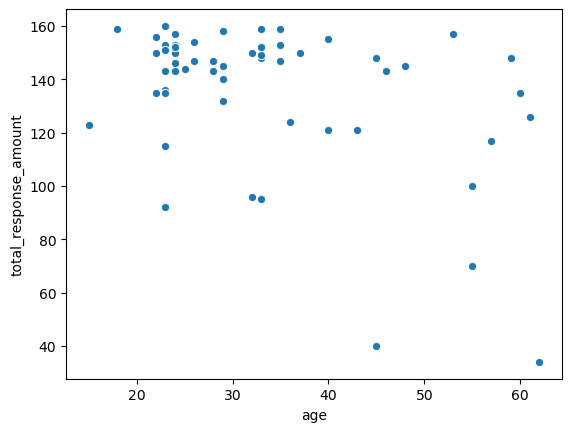

In [52]:
import seaborn as sns
sns.scatterplot(x="age", y="total_response_amount", data=df);

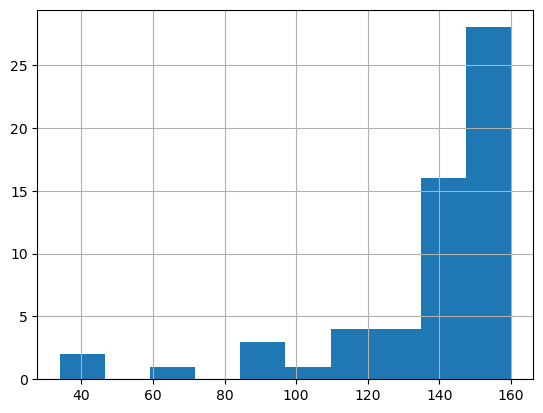

In [44]:
df["total_response_amount"].hist()

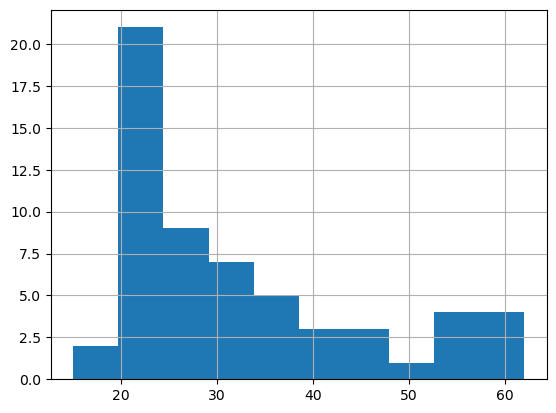

In [53]:
df["age"].hist()

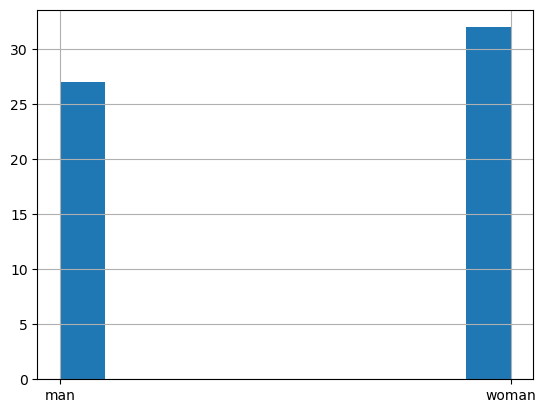

In [54]:
df["gender"].hist()

### Análisis Respuestas Correctas / Incorrectas

In [ ]:
def find_first_response(responses):
    for r in responses:
        if type(r) == str:
            return r
    return None

def find_second_response(responses):
    found_first = False
    for r in responses:
        if type(r) == str:
            if found_first:
                return r
            else:
                found_first = True
    return None

In [ ]:
def get_number_of_round(rows_of_round):
    return rows_of_round.iloc[0]['number']

def get_audio_of_round(rows_of_round):
    return rows_of_round.iloc[0]['audioFile']

In [ ]:
def audio_response_matches(audio_response, audio_stimulus):
    return (audio_response == 'a' and audio_stimulus == 'tones/440hz_short.mp3') or (audio_response == 's' and audio_stimulus == 'tones/880hz_short.mp3')

def number_response_matches(number_response, number_stimulus):
    try:
        number_stimulus = int(number_stimulus)
    except ValueError:
        number_stimulus = words_to_numbers[number_stimulus]

    return (number_response == 'j' and number_stimulus < 45) or (number_response == 'k' and number_stimulus > 45)


def responses_match_with_stimulus(audio_response, number_response, audio, number):
    audio = audio_response_matches(audio_response, audio)
    number = number_response_matches(number_response, number)
    return audio and number

In [ ]:
def responded_correcty_in_block_and_round(df, block, round):
    rows_of_that_round = df[(df['block'] == block) & (df['round'] == round)]
    number = get_number_of_round(rows_of_that_round)
    audio = get_audio_of_round(rows_of_that_round)
    responses = []
    for row in rows_of_that_round.itertuples(index=False):
        responses.append(row.response)

    audio_response = find_first_response(responses)
    number_response = find_second_response(responses)
    if audio_response == None or number_response == None:
        return False

    return responses_match_with_stimulus(audio_response, number_response, audio, number)

In [ ]:
def responses_results_for_df(df):
    """
    Retorna un arreglo de arreglos de booleanos, indicando para cada muestra si respondieron bien a ambos estímulos o no.
    El primer índice del arreglo que se retorna indica el bloque [0-3] y el segundo el número de ronda de ese bloque [0-39]
    """
    responded_correctly = [[None for _ in range(40)] for _ in range(4)]
    for block_id in range(0, 4):
        for round_id in range(0, 40):
            responded_correctly[block_id][round_id] = responded_correcty_in_block_and_round(df, block_id, round_id)
    return responded_correctly

In [ ]:
df_responses = responses_results_for_df(df)

In [ ]:
# Calculate the ratio of True values
total_elements = 4 * 40
total_true = sum(row.count(True) for row in df_responses)

ratio = total_true / total_elements

# Print the ratio
print(total_elements)
print(total_true)
print(f"Ratio: {ratio:.2%}")

In [ ]:
# Las rondas que corresponden a esas 10 respuestas incorrectas habría que sacarlas de la df.
# Podemos saber cuáles son encontrando los índices de los valores que son False en df_responses.

###  Análisis Tiempos de Respuesta
Acordarse primero de filtrar (eliminar) todos los que dieron false en responses_results_for_df.

Además, falta ver qué tipo de estímulo es el número (dígito o palabra). Eso se puede ver separando los bloques.

In [ ]:
# Sabemos que tenemos 4 bloques, de 40 rondas cada uno.

# Cada una de esas rondas puede tener 3 ó 4 tareas. ¿Pueden tener 2 también? Creo que sí.
# Fijarse eso por las dudas con groupby(['block', 'round']).size().value_counts().

In [ ]:
def get_delay_of_round(rows_of_round):
    return rows_of_round.iloc[0]['delay']

In [ ]:
def get_responses_time_of_block_and_round(df, block, round):

    response_time_audio, response_time_number = None, None
    first_task, second_task, third_task, fourth_task = None, None, None, None

    rows_of_that_round = df[(df['block'] == block) & (df['round'] == round)]

    # Si esas rondas fueron descartadas por respuestas incorrectas, no hay nada que hacer.
    if rows_of_that_round.empty:
        return None, None

    delay = get_delay_of_round(rows_of_that_round)
    first_task = rows_of_that_round.iloc[0]
    second_task = rows_of_that_round.iloc[1]
    third_task = rows_of_that_round.iloc[2]
    if len(rows_of_that_round) > 3:
        fourth_task = rows_of_that_round.iloc[3]

    if not math.isnan(first_task.rt):
        # respondimos durante la tone_number_task
        rt_tone_number_task = first_task.rt
        response_time_audio = rt_tone_number_task
        if second_task.task == 'delay_block':
            # entramos a delay->tone_number_task_remaining_before_delay (second y third tasks)
            if not math.isnan(third_task.rt):
                response_time_number = third_task.rt
            else:
                # no respondimos en remaining_before_delay, tenemos un empty block
                trial_duration_remaining_before_delay = 150.0 # el trial_duration de remaining_before_delay es siempre igual.
                response_time_number = fourth_task.rt + trial_duration_remaining_before_delay
        else:
            # second_task es 'remaining after delay'
            if not math.isnan(second_task.rt):
                response_time_number = second_task.rt + rt_tone_number_task - delay
            else: # vamos al empty block
                # no hace falta ver el trial_duration de la remaining_after_delay, porque ya tenemos el trial_duration de la tone_number_task:
                # tone_number_task.rt + remaining_after_delay.trial_duration = tone_number_task.trial_duration (ESTO SE CUMPLE SIEMPRE PORQUE ASÍ LO DEFINIMOS)
                response_time_number = third_task.rt + first_task.trial_duration - delay
    else:
        # no respondimos en la tone_number_task, tenemos dos empty blocks
        response_time_audio = second_task.rt + first_task.trial_duration
        response_time_number = third_task.rt + second_task.rt + first_task.trial_duration - delay


    return response_time_audio, response_time_number

In [ ]:
def response_times_for_df(df):
    """
    Retorna dos arreglos de arreglos de floats, indicando para cada ronda cuánto tardaron en responder a cada estímulo.
    El primer índice del arreglo que se retorna indica el bloque [0-3] y el segundo el número de ronda de ese bloque [0-39].
    """
    audio_response_times = [[None for _ in range(40)] for _ in range(4)]
    number_response_times = [[None for _ in range(40)] for _ in range(4)]
    for block_id in range(0, 4):
        for round_id in range(0, 40):
            audio_time, number_time = get_responses_time_of_block_and_round(df, block_id, round_id)
            audio_response_times[block_id][round_id] = audio_time
            number_response_times[block_id][round_id] = number_time
    return audio_response_times, number_response_times

In [ ]:
df_audio_rts, df_number_rts = response_times_for_df(df)
df_audio_rts_flat = [rt for block in df_audio_rts for rt in block]
df_number_rts_flat = [rt for block in df_number_rts for rt in block]

In [ ]:
# mean of a list of floats
def mean(lst):
    return sum(lst) / len(lst)

# mean of a list of floats, ignoring nan values. with only 2 decimal places.
def mean_ignore_nan(lst):
    lst_without_nans = [x for x in lst if not math.isnan(x)]
    return round(mean(lst_without_nans), 2)

In [ ]:
print(mean_ignore_nan(df_audio_rts_flat))
print(mean_ignore_nan(df_number_rts_flat))

¿No es raro que tarde casi lo mismo? Revisar bien el cálculo de los response times.